# What is the voltage clamp current trajectory needed to force the membrane voltage to follow a short current pulse stimulated action potential?

### A depolarizing voltage clamp step exhibits the famous inward sodium current followed by outward potassium current

<img src="vclamp_step.png" width="60%"/>

### But what is the current if the voltage clamp control voltage is ...

<img src="iclamp_ap.png" width="30%"/>

## Strategy
1) Create a single compartment hh model.
2) Record an action potential elicited by  a short current pulse.
3) Replace the current clamp with a voltage clamp.
4) Play the recorded action potential into the voltage clamp control voltage.
5) Plot the voltage clamp current.

In [1]:
%matplotlib inline
from neuron import h
h.load_file("stdrun.hoc") # provides h.run()


1.0

Arena: 100 um2 cell. 100um2 means 1 nA = 1 mA/cm2

In [2]:
soma = h.Section("soma")
soma.diam = 10
soma.L = 100/h.PI/soma.diam
print(soma(0.5).area())

99.99999999999999


Standard Hodgkin-Huxley channels with short current stimulus to generate an Action Potential

In [3]:
soma.insert("hh")
ic = h.IClamp(soma(.5))
ic.delay = 1
ic.dur = .1
ic.amp = .3

Plot current and voltage

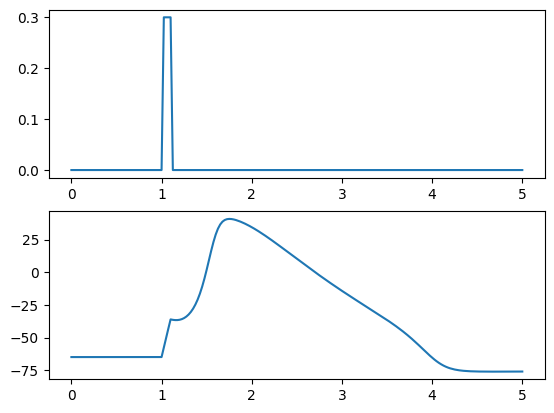

In [4]:
tvec = h.Vector().record(h._ref_t, sec=soma)
ivec = h.Vector().record(ic._ref_i, sec=soma)
vvec = h.Vector().record(soma(.5)._ref_v, sec=soma)
def run():
    h.run()
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(2,1)
    ax[0].plot(tvec, ivec)
    ax[1].plot(tvec, vvec)
    plt.show()
run()

Turn off the current clamp and play the voltage trajectory into a voltage clamp. What will the clamp current be?

In [5]:
ic.delay = 1e9
vcstim = vvec.c()
tstim = tvec.c()
vc = h.SEClamp(soma(.5))
vc.dur1 = 1e9
vc.rs = 0.1  # MOhm
vcstim.play(vc._ref_amp1, tstim)
ivec = h.Vector()
ivec.record(vc._ref_i)


Vector[5]

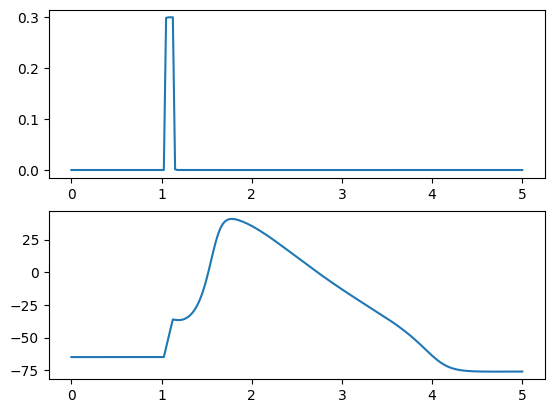

In [6]:
run()

But what if cvode is turned on.

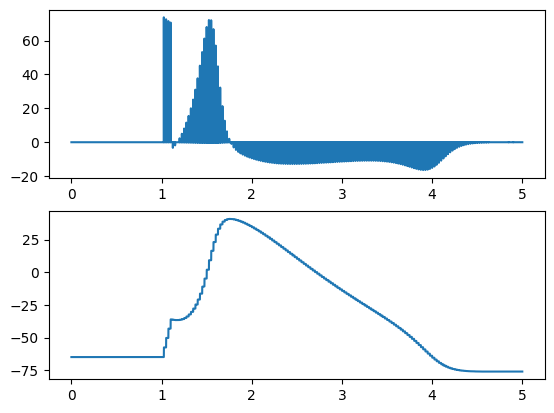

In [7]:
h.cvode_active(1)
run()

The voltage is following a step functon andthe current trajectory is filled with capacity transients. As well as significant current to keep the trajectory transiently on short horizontal lines.

Lets treat the voltage clamp control trajectory as a piecewise linear function.

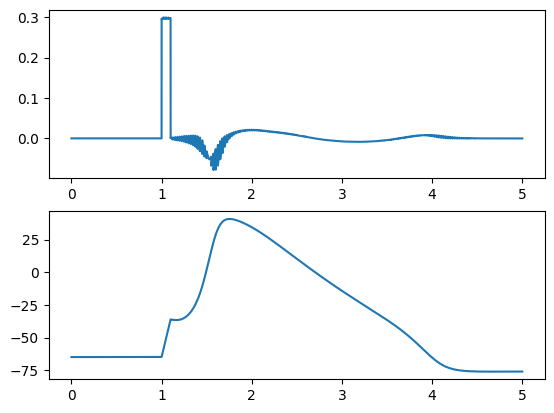

In [8]:
vcstim.play(vc._ref_amp1, tstim, 1)
run()

Switch back to current clamp and increase fixed step accuracy without increasing size of vector trajectory. To get the same size trajectory, just interpolate to the original tvec.

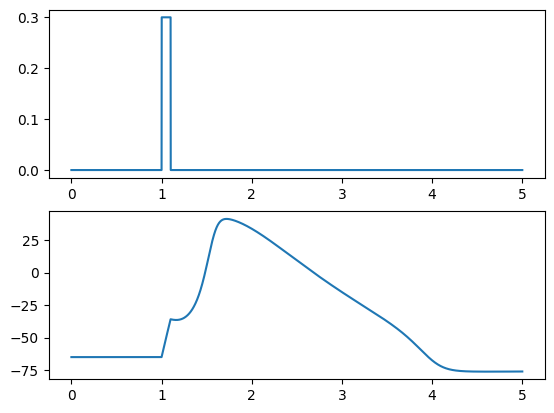

3201
201


In [9]:
h.cvode_active(0)
ic.delay = 1
vc.rs = 1e9
h.dt = 0.025/16
ivec.record(ic._ref_i)
run()
print(tvec.size())
vcstim.interpolate(tstim, tvec, vvec)
print(vcstim.size())


Now how similar is the vclamp current to the original cvode trajectory

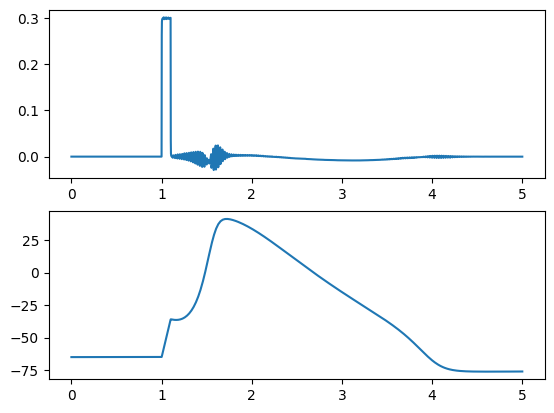

In [10]:
h.cvode_active(1)
ic.delay = 1e9
vc.rs = 1
ivec.record(vc._ref_i)
run()

I expected the error in the last figure above to be less. Would it have been less if I had used the full 3201 point vvec and tvec from the previous current clamp trajectory? Or is the error due to the use of a non-ideal voltage clamp (can decrease vc.rs). What about using an even more accurate simulation during the current clamp gathering phase by using cvode? The LinearCircuitBuilder can simulate an ideal voltage clamp by using just a battery for the linear circuit and playing the voltage trajectory into the battery.